# Google colab initialization

For Google colab uncomment these lines and run them to access your drive or try the second way (not tested)

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# import sys
#
# sys.path.insert(1, r'/content/drive/My Drive/')

In [3]:
# Other try
# !git clone https://github.com/Alexanderstaehle/OM_project

In [4]:
# import sys
# sys.path.append("OM_project")

In [5]:
import numpy as np
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras

from utils import ml_utils, visualization, data_loading, tf_models

In [6]:
RETRAIN_FLAG = True

In [ ]:
RETRAIN_FLAG = False

In [7]:
filename_bs = lambda bs: ml_utils.path_from_filename(f'model_fixed_lr_diff_bs_{bs}', format_="tf")
filename_bs_lr = lambda bs, lr: ml_utils.path_from_filename(f'model_lr_{lr}_diff_bs_{bs}', format_="tf")

In [8]:
filename_bs_opt_sam = lambda bs, opt, sam: ml_utils.path_from_filename(
    f'model_fixed_lr_diff_bs_{bs}_opt_{opt}_sam_{sam}', format_="tf")
filename_bs_lr_opt_sam = lambda bs, lr, opt, sam: ml_utils.path_from_filename(
    f'model_lr_{lr}_diff_bs_{bs}_opt_{opt}_sam_{sam}', format_="tf")

In [9]:
def build_and_load_sam_model_weights(train, optimizer, filename, adaptive=False, rho=0.05):
    model = tf_models.build_simple_cnn_sam(train, optimizer)
    model.load_weights(filename)
    return model

In [10]:
RETRAIN_FLAG = True
data_loading.initialize_env()
sns.set_theme()
color_map = sns.color_palette(as_cmap=True)
ml_utils.check_tpu_gpu()

2022-02-21 15:08:02.131501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 15:08:02.213135: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 15:08:02.213592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of accelerators:  1


2022-02-21 15:08:02.216577: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-21 15:08:02.219197: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 15:08:02.219589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 15:08:02.219882: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# Different batch sizes with fixed learning rate

## with sharpness aware minimization

### SGD with Momentum + SAM 

In [11]:
models_dict_fixed = {}
batch_sizes = [32, 64, 128, 256, 512, 1024]
#batch_sizes = [32]
lr = 0.001
training_epochs = 10

In [12]:
models_by_batch_size_fixed_lr = {}

In [13]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST', batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_sam_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "SGD-MOM", "SAM"))
        models_by_batch_size_fixed_lr[batch_size] = model

In [14]:
if RETRAIN_FLAG:
    # Need sparse categorical crossentropy since our labels are in form of integers not vectors
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST', batch_size=batch_size,
                                                                          img_size=32)

        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = tf_models.build_simple_cnn_sam(train, optimizer)

        train_callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=10,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ModelCheckpoint(
                filename_bs_opt_sam(batch_size, "SGD-MOM", "SAM"),
                monitor='val_loss',
                mode='min',
                verbose=1,
                save_best_only=True,
                save_weights_only=True
            )
            # tf.keras.callbacks.ReduceLROnPlateau(
            #     monitor="val_loss", factor=0.5,
            #     patience=3, verbose=1
            # )
        ]
        models_dict_fixed[batch_size] = ml_utils.train_model(model, train, validation, epochs=10,
                                                             extra_callbacks=train_callbacks, verbose=1)
        models_by_batch_size_fixed_lr[batch_size] = model

Epoch 1/10


2022-02-21 15:08:05.093659: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-02-21 15:08:06.153233: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1486/1500 [============================>.] - ETA: 0s - loss: 0.7504 - accuracy: 0.7449
Epoch 1: val_loss improved from inf to 0.24957, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 9s 4ms/step - loss: 0.7464 - accuracy: 0.7463 - val_loss: 0.2496 - val_accuracy: 0.9342
Epoch 2/10
1495/1500 [============================>.] - ETA: 0s - loss: 0.2350 - accuracy: 0.9181
Epoch 2: val_loss improved from 0.24957 to 0.15935, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2348 - accuracy: 0.9182 - val_loss: 0.1594 - val_accuracy: 0.9589
Epoch 3/10
1500/1500 [==============================] - ETA: 0s - loss: 0.1736 - accuracy: 0.9371
Epoch 3: val_loss improved from 0.15935 to 0.12719, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1736 - accuracy: 0.9371 -

375/375 [==============================] - 3s 8ms/step - loss: 0.2965 - accuracy: 0.9004 - val_loss: 0.2406 - val_accuracy: 0.9358
Epoch 5/10
371/375 [============================>.] - ETA: 0s - loss: 0.2498 - accuracy: 0.9165
Epoch 5: val_loss improved from 0.24061 to 0.20479, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 4s 9ms/step - loss: 0.2498 - accuracy: 0.9166 - val_loss: 0.2048 - val_accuracy: 0.9463
Epoch 6/10
369/375 [============================>.] - ETA: 0s - loss: 0.2160 - accuracy: 0.9282
Epoch 6: val_loss improved from 0.20479 to 0.17908, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.2159 - accuracy: 0.9283 - val_loss: 0.1791 - val_accuracy: 0.9528
Epoch 7/10
372/375 [============================>.] - ETA: 0s - loss: 0.1917 - accuracy: 0.9359
Epoch 7: val_loss improved from 0.17908 to 0.16049, saving model to tmp/mod

94/94 [==============================] - ETA: 0s - loss: 0.4260 - accuracy: 0.8509
Epoch 8: val_loss improved from 0.39560 to 0.36820, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.4260 - accuracy: 0.8509 - val_loss: 0.3682 - val_accuracy: 0.8947
Epoch 9/10
93/94 [============================>.] - ETA: 0s - loss: 0.3990 - accuracy: 0.8621
Epoch 9: val_loss improved from 0.36820 to 0.34578, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3990 - accuracy: 0.8620 - val_loss: 0.3458 - val_accuracy: 0.9012
Epoch 10/10
94/94 [==============================] - ETA: 0s - loss: 0.3771 - accuracy: 0.8712
Epoch 10: val_loss improved from 0.34578 to 0.32785, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 24ms/step - loss: 0.3771 - accuracy: 0.8712 - val_loss: 0

In [15]:
fixed_lr_state_filename = 'model_fixed_lr_diff_bs_state'

In [16]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_dict_fixed, fixed_lr_state_filename)
else:
    models_dict_fixed = ml_utils.load_model_state(fixed_lr_state_filename)

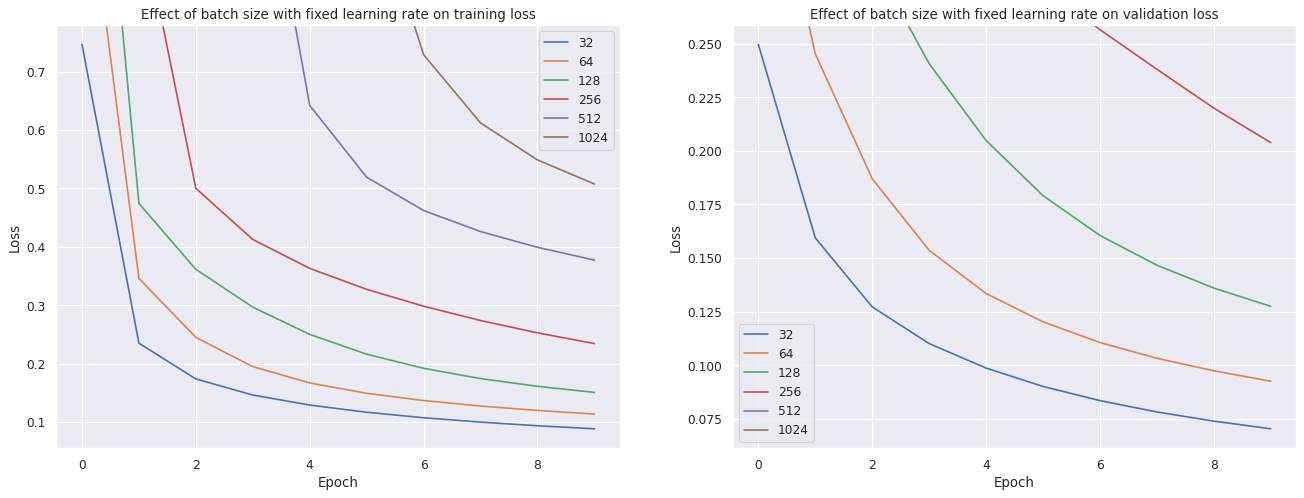

<Figure size 432x288 with 0 Axes>

In [17]:
visualization.plot_loss_by_param(models_dict_fixed, 'batch size with fixed learning rate', 'fixed_lr_diff_bs')

#### sharpness

In [18]:
sharpnesses = {}

In [19]:
for batch_size in batch_sizes:
    model = models_by_batch_size_fixed_lr[batch_size]

    sharpness_bs = visualization.get_sharpness(model.base_model, train)
    sharpnesses[batch_size] = sharpness_bs

47/47 [==============================] - 1s 13ms/step - loss: 0.0617 - accuracy: 0.9834
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.17384D-02    |proj g|=  1.58387D-02
47/47 [==============================] - 1s 12ms/step - loss: 4.1484 - accuracy: 0.3380

At iterate    1    f= -4.14840D+00    |proj g|=  3.16774D-02
  ys=-3.734E+02  -gs= 5.064E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 22.0871 - accuracy: 0.1322

At iterate    2    f= -2.20871D+01    |proj g|=  2.57621D-02
  ys=-1.293E+03  -gs= 2.593E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 30.2063 - accuracy: 0.0974

At iterate    3    f= -3.02063D+01    |proj g|=  2.43631D-02
  ys=-3.045E+02  -gs= 2.256E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 31.7482 - acc


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


47/47 [==============================] - 1s 16ms/step - loss: 0.0860 - accuracy: 0.9763
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.59538D-02    |proj g|=  1.63111D-02
47/47 [==============================] - 1s 11ms/step - loss: 5.7417 - accuracy: 0.3398

At iterate    1    f= -5.74173D+00    |proj g|=  3.26222D-02
  ys=-4.223E+02  -gs= 7.996E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 24.3172 - accuracy: 0.0976

At iterate    2    f= -2.43172D+01    |proj g|=  2.43396D-02
  ys=-1.312E+03  -gs= 2.805E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 32.9336 - accuracy: 0.0974

At iterate    3    f= -3.29336D+01    |proj g|=  2.33476D-02
  ys=-2.934E+02  -gs= 2.674E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 34.0101 - acc


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 12ms/step - loss: 34.8955 - accuracy: 0.0974

At iterate    9    f= -3.48955D+01    |proj g|=  2.24906D-02
47/47 [==============================] - 1s 13ms/step - loss: 34.8978 - accuracy: 0.0974

At iterate   10    f= -3.48978D+01    |proj g|=  1.42166D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786     10     12  64476     7 55219   1.422D-02  -3.490D+01
  F =  -34.897819519042969     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
47/47 [==============================] - 1s 13ms/step - loss: 0.1224 - accuracy: 0.9660
RUNNING THE L-BFGS-B CODE

      


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


47/47 [==============================] - 1s 15ms/step - loss: 0.2008 - accuracy: 0.9430
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.00788D-01    |proj g|=  1.42937D-02
47/47 [==============================] - 1s 11ms/step - loss: 9.0727 - accuracy: 0.3642

At iterate    1    f= -9.07268D+00    |proj g|=  2.85874D-02
  ys=-5.882E+02  -gs= 1.449E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 29.5031 - accuracy: 0.2923

At iterate    2    f= -2.95031D+01    |proj g|=  2.30643D-02
  ys=-1.181E+03  -gs= 4.143E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 10ms/step - loss: 32.8551 - accuracy: 0.2902

At iterate    3    f= -3.28551D+01    |proj g|=  2.29402D-02
  ys=-1.504E+02  -gs= 9.303E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 33.4878 - acc


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


47/47 [==============================] - 1s 16ms/step - loss: 0.3273 - accuracy: 0.9053
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.27257D-01    |proj g|=  1.40712D-02
47/47 [==============================] - 1s 12ms/step - loss: 5.4475 - accuracy: 0.4818

At iterate    1    f= -5.44746D+00    |proj g|=  2.81425D-02
  ys=-2.328E+02  -gs= 2.426E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 10ms/step - loss: 27.6519 - accuracy: 0.2883

At iterate    2    f= -2.76519D+01    |proj g|=  2.29954D-02
  ys=-1.491E+03  -gs= 3.273E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 33.5996 - accuracy: 0.2883

At iterate    3    f= -3.35996D+01    |proj g|=  2.20212D-02
  ys=-1.695E+02  -gs= 2.049E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 34.1068 - acc


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


47/47 [==============================] - 1s 16ms/step - loss: 0.4346 - accuracy: 0.8750
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.34557D-01    |proj g|=  1.33720D-02
47/47 [==============================] - 1s 12ms/step - loss: 6.1867 - accuracy: 0.4194

At iterate    1    f= -6.18668D+00    |proj g|=  2.67440D-02
  ys=-1.454E+02  -gs= 2.618E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 26.3465 - accuracy: 0.3669

At iterate    2    f= -2.63465D+01    |proj g|=  2.32638D-02
  ys=-9.419E+02  -gs= 5.123E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 30.0541 - accuracy: 0.3753

At iterate    3    f= -3.00541D+01    |proj g|=  2.19575D-02
  ys=-1.795E+02  -gs= 9.807E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 30.4697 - acc


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 12ms/step - loss: 30.6088 - accuracy: 0.3761

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      9     11  68413     7 58580   1.965D-03  -3.061D+01
  F =  -30.608846664428711     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [20]:
sharpnesses

{32: 3003.1663479296653,
 64: 3205.64893240265,
 128: 3255.5206833838724,
 256: 2779.7364701439465,
 512: 2549.097672173616,
 1024: 2103.3869877009506}

In [21]:
mean_times = []
convergence_epochs = []
overall_training_times = []

for batch_size in batch_sizes:
    # Compute mean epoch time, num epochs to converge, overall training time
    state = models_dict_fixed[batch_size]
    mean_time_per_epoch = np.mean(state.times)
    convergence_epoch = np.argmin(state.history['val_loss'])
    overall_training_time = np.sum(state.times[:convergence_epoch])

    # Append results
    convergence_epochs.append(convergence_epoch)
    mean_times.append(mean_time_per_epoch)
    overall_training_times.append(overall_training_time)

    print("Batch size: ", batch_size)
    print("\tMean time per epoch: ", mean_time_per_epoch)
    print("\tConverged in {} epochs".format(convergence_epoch))
    print("\tOverall training time (in seconds) until convergence: ", overall_training_time)

Batch size:  32
	Mean time per epoch:  7.524195432662964
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  69.20030689239502
Batch size:  64
	Mean time per epoch:  4.6009073734283445
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  41.12497806549072
Batch size:  128
	Mean time per epoch:  3.1095355272293093
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  28.059664249420166
Batch size:  256
	Mean time per epoch:  2.697234320640564
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  24.310871601104736
Batch size:  512
	Mean time per epoch:  2.4335310459136963
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  22.08053207397461
Batch size:  1024
	Mean time per epoch:  2.3931528091430665
	Converged in 9 epochs
	Overall training time (in seconds) until convergence:  21.67291760444641


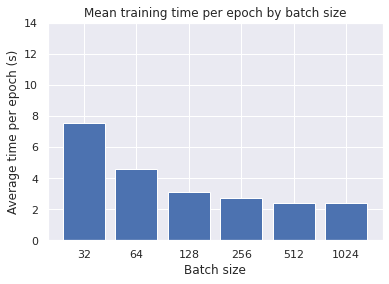

<Figure size 432x288 with 0 Axes>

In [22]:
rects = plt.bar(x=range(len(batch_sizes)), height=mean_times, tick_label=batch_sizes)
plt.xlabel('Batch size')
plt.ylabel('Average time per epoch (s)')
plt.ylim(0, 14)
plt.title('Mean training time per epoch by batch size')
plt.show()
plt.savefig('graphs/mean_epoch_training_time_by_batch_size')

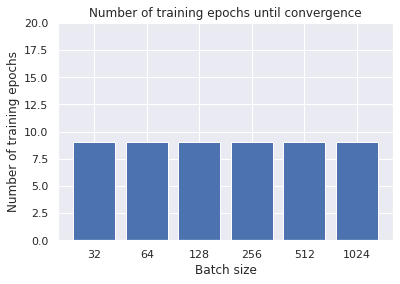

<Figure size 432x288 with 0 Axes>

In [23]:
rects = plt.bar(x=range(len(batch_sizes)), height=convergence_epochs, tick_label=batch_sizes)
plt.xlabel('Batch size')
plt.ylabel('Number of training epochs')
plt.ylim(0, 20)
plt.title('Number of training epochs until convergence')
plt.show()
plt.savefig('graphs/num_training_epochs_by_batch_size')

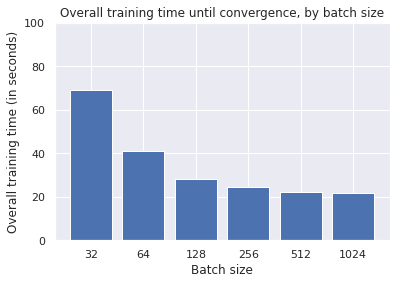

<Figure size 432x288 with 0 Axes>

In [24]:
rects = plt.bar(x=range(len(batch_sizes)), height=overall_training_times, tick_label=batch_sizes)
plt.xlabel('Batch size')
plt.ylabel('Overall training time (in seconds)')
plt.ylim(0, 100)
plt.title('Overall training time until convergence, by batch size')
plt.show()
plt.savefig('graphs/overall_training_time_by_batch_size')

- loss curve
- val loss curve
- final train and val loss (best) 
- sharpness of the minimizers 
- distance from initial weights

- training time
- training time per epoch 
- epochs needed to converge 
- parallelization 
- training time times sharpness

### SGD with Momentum + ASAM

### ADAM + SAM 

### ADAM + ASAM

## without sharpness aware minimization

### SGD with Momemtum

### ADAM

# Different batch sizes with linear increasing learning rate

## with sharpness aware minimization

### SGD with Momentum + SAM 

In [25]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = 10

In [26]:
models_by_batch_size_diff_lr = {}
model_history_dict_diff_lr = {}

In [27]:
diff_lr_state_filename = 'model_diff_lr_diff_bs_state'

In [28]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST', batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_sam_model_weights(train, optimizer,
                                                 filename_bs_lr_opt_sam(batch_size, lr, "SGD-MOM", "SAM"))
        models_by_batch_size_diff_lr[batch_size] = model

In [29]:
if RETRAIN_FLAG:
    # Need sparse categorical crossentropy since our labels are in form of integers not vectors
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST', batch_size=batch_size,
                                                                          img_size=32)

        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = tf_models.build_simple_cnn_sam(train, optimizer)

        train_callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=10,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ModelCheckpoint(
                filename_bs_opt_sam(batch_size, "SGD-MOM", "SAM"),
                monitor='val_loss',
                mode='min',
                verbose=1,
                save_best_only=True,
                save_weights_only=True
            )
            # tf.keras.callbacks.ReduceLROnPlateau(
            #     monitor="val_loss", factor=0.5,
            #     patience=3, verbose=1
            # )
        ]
        model_history_dict_diff_lr[batch_size] = ml_utils.train_model(model, train, validation, epochs=10,
                                                                      extra_callbacks=train_callbacks, verbose=1)
        models_by_batch_size_diff_lr[batch_size] = model

Epoch 1/10
1496/1500 [============================>.] - ETA: 0s - loss: 0.7346 - accuracy: 0.7512
Epoch 1: val_loss improved from inf to 0.24541, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 7s 4ms/step - loss: 0.7333 - accuracy: 0.7517 - val_loss: 0.2454 - val_accuracy: 0.9345
Epoch 2/10
1496/1500 [============================>.] - ETA: 0s - loss: 0.2286 - accuracy: 0.9188
Epoch 2: val_loss improved from 0.24541 to 0.15532, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2285 - accuracy: 0.9189 - val_loss: 0.1553 - val_accuracy: 0.9592
Epoch 3/10
1496/1500 [============================>.] - ETA: 0s - loss: 0.1693 - accuracy: 0.9384
Epoch 3: val_loss improved from 0.15532 to 0.12434, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 10s 7ms/step - loss: 0.1692 - accura

375/375 [==============================] - 3s 8ms/step - loss: 0.1297 - accuracy: 0.9553 - val_loss: 0.1085 - val_accuracy: 0.9694
Epoch 5/10
375/375 [==============================] - ETA: 0s - loss: 0.1145 - accuracy: 0.9605
Epoch 5: val_loss improved from 0.10848 to 0.09746, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 8ms/step - loss: 0.1145 - accuracy: 0.9605 - val_loss: 0.0975 - val_accuracy: 0.9729
Epoch 6/10
371/375 [============================>.] - ETA: 0s - loss: 0.1038 - accuracy: 0.9643
Epoch 6: val_loss improved from 0.09746 to 0.08958, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 3s 9ms/step - loss: 0.1039 - accuracy: 0.9642 - val_loss: 0.0896 - val_accuracy: 0.9749
Epoch 7/10
374/375 [============================>.] - ETA: 0s - loss: 0.0958 - accuracy: 0.9669
Epoch 7: val_loss improved from 0.08958 to 0.08354, saving model to tmp/mod

94/94 [==============================] - ETA: 0s - loss: 0.0803 - accuracy: 0.9725
Epoch 8: val_loss improved from 0.08232 to 0.07703, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.0803 - accuracy: 0.9725 - val_loss: 0.0770 - val_accuracy: 0.9771
Epoch 9/10
94/94 [==============================] - ETA: 0s - loss: 0.0750 - accuracy: 0.9741
Epoch 9: val_loss improved from 0.07703 to 0.07218, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.0750 - accuracy: 0.9741 - val_loss: 0.0722 - val_accuracy: 0.9788
Epoch 10/10
93/94 [============================>.] - ETA: 0s - loss: 0.0706 - accuracy: 0.9758
Epoch 10: val_loss improved from 0.07218 to 0.06804, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 2s 25ms/step - loss: 0.0707 - accuracy: 0.9757 - val_loss: 0

In [30]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(model_history_dict_diff_lr, diff_lr_state_filename)
else:
    model_history_dict_diff_lr = ml_utils.load_model_state(diff_lr_state_filename)

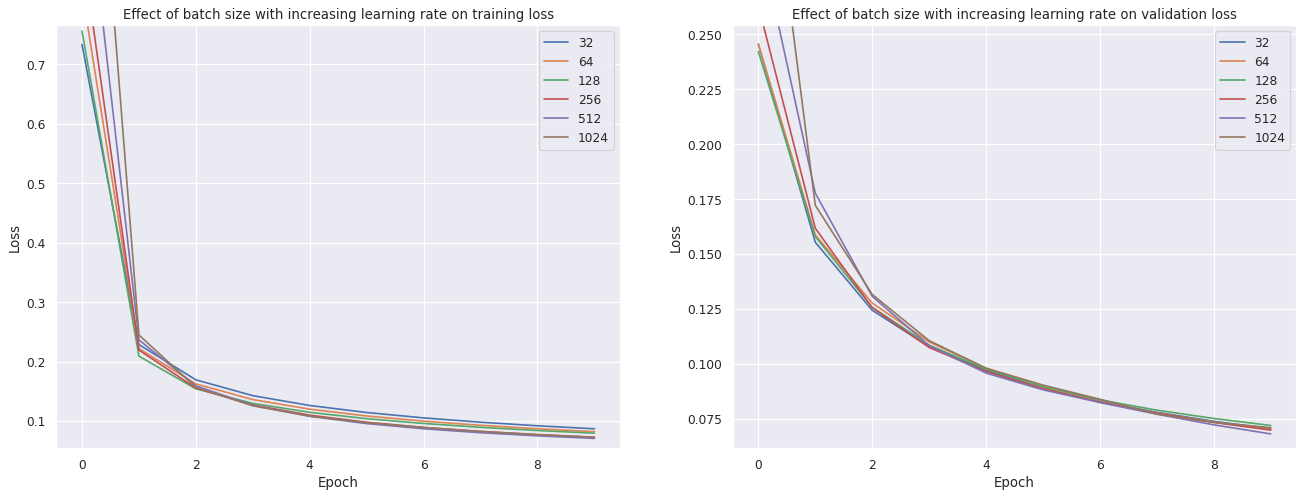

<Figure size 432x288 with 0 Axes>

In [34]:
visualization.plot_loss_by_param(model_history_dict_diff_lr, 'batch size with increasing learning rate',
                                 'diff_lr_diff_bs')

#### sharpness

In [35]:
sharpnesses_diff = {}

for batch_size in batch_sizes:
    model = models_by_batch_size_diff_lr[batch_size]

    sharpness_bs = visualization.get_sharpness(model.base_model, train)
    sharpnesses_diff[batch_size] = sharpness_bs

47/47 [==============================] - 1s 14ms/step - loss: 0.0614 - accuracy: 0.9832
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.14465D-02    |proj g|=  1.44559D-02
47/47 [==============================] - 1s 11ms/step - loss: 3.5434 - accuracy: 0.3576

At iterate    1    f= -3.54342D+00    |proj g|=  2.89119D-02
  ys=-3.093E+02  -gs= 4.977E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 22.0889 - accuracy: 0.1824

At iterate    2    f= -2.20889D+01    |proj g|=  2.62409D-02
  ys=-1.372E+03  -gs= 2.488E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 28.1993 - accuracy: 0.1914

At iterate    3    f= -2.81993D+01    |proj g|=  2.34088D-02
  ys=-2.810E+02  -gs= 1.615E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 29.6715 - acc

47/47 [==============================] - 1s 13ms/step - loss: 34.8438 - accuracy: 0.1913

At iterate   10    f= -3.48438D+01    |proj g|=  2.12257D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786     10     11  60835     9 56445   2.123D-02  -3.484D+01
  F =  -34.843753814697266     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
47/47 [==============================] - 1s 14ms/step - loss: 0.0592 - accuracy: 0.9837
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 12ms/step - loss: 34.4818 - accuracy: 0.1969

At iterate   10    f= -3.44818D+01    |proj g|=  2.10923D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786     10     12  60212     8 53530   2.109D-02  -3.448D+01
  F =  -34.481838226318359     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
47/47 [==============================] - 1s 13ms/step - loss: 0.0575 - accuracy: 0.9835
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 13ms/step - loss: 34.0243 - accuracy: 0.1972

At iterate    7    f= -3.40243D+01    |proj g|=  2.25654D-02
  ys=-7.432E-01  -gs= 1.343E-01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 34.0365 - accuracy: 0.1972

At iterate    8    f= -3.40365D+01    |proj g|=  2.19291D-02
  ys=-5.420E-01  -gs= 3.245E-01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 34.0440 - accuracy: 0.1972

At iterate    9    f= -3.40440D+01    |proj g|=  2.21746D-02
  ys=-3.062E-01  -gs= 2.076E-01 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 34.0497 - accuracy: 0.1971

At iterate   10    f= -3.40497D+01    |proj g|=  2.26477D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at fi

In [36]:
sharpnesses_diff

{32: 2829.034746599956,
 64: 2902.9702169332545,
 128: 3275.80177856265,
 256: 3249.8754159377554,
 512: 3214.302966768265,
 1024: 2524.408151878001}